## 起始設定

In [16]:
import talib
import numpy as np
import pandas as pd
from finlab.data import Data

folder = '/Users/yungching/Documents/history'

stock_id = '2412'

data = Data(folder)

## 取得預設持有報酬率

In [32]:
open_adj = data.get_adj('開盤價')

profit1 =  open_adj.shift(-2) / open_adj.shift(-1)
profit5 =  open_adj.shift(-6) / open_adj.shift(-1)
profit10 = open_adj.shift(-11) / open_adj.shift(-1)
profit60 = open_adj.shift(-61) / open_adj.shift(-1)

profit1 = profit1[stock_id]
profit5 = profit5[stock_id]
profit10 = profit10[stock_id]
profit60 = profit60[stock_id]

date
2007-04-23    0.979876
2007-04-24    0.987597
2007-04-25    0.982812
2007-04-26    0.998420
2007-04-27    1.000000
                ...   
2019-06-24         NaN
2019-06-25         NaN
2019-06-26         NaN
2019-06-27         NaN
2019-06-28         NaN
Name: 2412, Length: 3014, dtype: float64

In [ ]:
profit10

## 分析candlestick

In [66]:
from talib import abstract

strategies = {}

candlesticks = [fname for fname in dir(abstract) if fname[:3] == 'CDL']

for index, fname in enumerate(candlesticks, 1):
    print(f'{index}/{len(candlesticks)}: {fname} is running')

    df = data.talib(fname)

    stock_series = df[df[stock_id] != 0][stock_id]

    stock_series = stock_series.dropna(axis=0)

    if stock_series.empty:
        continue

    pos = stock_series > 0
    neg = stock_series < 0

    strategies[fname] = {
        "positive": stock_series[pos],
        "positive_profilt_1": profit1[profit1.index.isin(pos.index)],
        "positive_profilt_5": profit5[profit5.index.isin(pos.index)],
        "positive_profilt_10": profit10[profit10.index.isin(pos.index)],
        "negative": stock_series[neg],
        "negative_profilt_1": profit1[profit1.index.isin(neg.index)],
        "negative_profilt_5": profit5[profit5.index.isin(neg.index)],
        "negative_profilt_10": profit10[profit10.index.isin(neg.index)],
    }

1/61: CDL2CROWS is running
2/61: CDL3BLACKCROWS is running
3/61: CDL3INSIDE is running
4/61: CDL3LINESTRIKE is running
5/61: CDL3OUTSIDE is running
6/61: CDL3STARSINSOUTH is running
7/61: CDL3WHITESOLDIERS is running
8/61: CDLABANDONEDBABY is running
9/61: CDLADVANCEBLOCK is running
10/61: CDLBELTHOLD is running
11/61: CDLBREAKAWAY is running
12/61: CDLCLOSINGMARUBOZU is running
13/61: CDLCONCEALBABYSWALL is running
14/61: CDLCOUNTERATTACK is running
15/61: CDLDARKCLOUDCOVER is running
16/61: CDLDOJI is running
17/61: CDLDOJISTAR is running
18/61: CDLDRAGONFLYDOJI is running
19/61: CDLENGULFING is running
20/61: CDLEVENINGDOJISTAR is running
21/61: CDLEVENINGSTAR is running
22/61: CDLGAPSIDESIDEWHITE is running
23/61: CDLGRAVESTONEDOJI is running
24/61: CDLHAMMER is running
25/61: CDLHANGINGMAN is running
26/61: CDLHARAMI is running
27/61: CDLHARAMICROSS is running
28/61: CDLHIGHWAVE is running
29/61: CDLHIKKAKE is running
30/61: CDLHIKKAKEMOD is running
31/61: CDLHOMINGPIGEON is runni

In [19]:
for name, strategy in strategies.items():
    print(name)
    print('positive: ' + str(len(strategy['positive'])))
    print('negative: ' + str(len(strategy['negative'])))

CDL3INSIDE
positive: 10
negative: 6
CDL3OUTSIDE
positive: 13
negative: 16
CDL3WHITESOLDIERS
positive: 8
negative: 0
CDLADVANCEBLOCK
positive: 0
negative: 8
CDLBELTHOLD
positive: 313
negative: 330
CDLBREAKAWAY
positive: 1
negative: 0
CDLCLOSINGMARUBOZU
positive: 411
negative: 303
CDLCOUNTERATTACK
positive: 6
negative: 8
CDLDOJI
positive: 639
negative: 0
CDLDOJISTAR
positive: 18
negative: 24
CDLDRAGONFLYDOJI
positive: 135
negative: 0
CDLENGULFING
positive: 31
negative: 39
CDLEVENINGDOJISTAR
positive: 0
negative: 1
CDLEVENINGSTAR
positive: 0
negative: 11
CDLGAPSIDESIDEWHITE
positive: 18
negative: 9
CDLGRAVESTONEDOJI
positive: 120
negative: 0
CDLHAMMER
positive: 51
negative: 0
CDLHANGINGMAN
positive: 0
negative: 174
CDLHARAMI
positive: 58
negative: 57
CDLHARAMICROSS
positive: 26
negative: 25
CDLHIGHWAVE
positive: 397
negative: 38
CDLHIKKAKE
positive: 75
negative: 88
CDLHIKKAKEMOD
positive: 1
negative: 1
CDLHOMINGPIGEON
positive: 17
negative: 0
CDLINNECK
positive: 0
negative: 6
CDLINVERTEDH

In [33]:
strategies['CDL3INSIDE']

{'positive': date
 2007-07-17    100
 2008-09-18    100
 2009-11-09    100
 2010-02-23    100
 2011-04-19    100
 2013-06-28    100
 2013-09-10    100
 2014-10-21    100
 2015-03-18    100
 2015-04-10    100
 Name: 2412, dtype: int32,
 'positive_profilt_1': date
 2007-04-26    1.0
 2007-05-15    1.0
 2007-05-21    1.0
 2007-05-25    1.0
 2007-06-01    1.0
              ... 
 2019-06-13    1.0
 2019-06-18    1.0
 2019-06-19    1.0
 2019-06-21    1.0
 2019-06-25    1.0
 Name: 2412, Length: 606, dtype: float64,
 'positive_profilt_5': date
 2007-05-04    1.0
 2007-06-23    1.0
 2007-09-03    1.0
 2007-11-13    1.0
 2007-12-03    1.0
              ... 
 2019-05-23    1.0
 2019-05-24    1.0
 2019-06-03    1.0
 2019-06-04    1.0
 2019-06-13    1.0
 Name: 2412, Length: 267, dtype: float64,
 'positive_profilt_10': Series([], Name: 2412, dtype: float64),
 'negative': date
 2007-10-31   -100
 2008-04-30   -100
 2009-04-15   -100
 2013-01-03   -100
 2014-03-04   -100
 2014-05-30   -100
 Name: 2412

date
2007-05-11   -0.007901
2007-05-18    0.006319
2007-05-25    0.000000
2007-07-06    0.007937
2007-07-11   -0.001607
                ...   
2019-06-06   -0.013177
2019-06-10    0.008772
2019-06-11    0.004464
2019-06-17         NaN
2019-06-27         NaN
Name: positive_profilt_1, Length: 643, dtype: float64
date
2007-05-11   -0.007901
2007-05-18   -0.001582
2007-05-25   -0.001582
2007-07-06    0.006354
2007-07-11    0.004747
                ...   
2019-06-06   -0.024263
2019-06-10   -0.015492
2019-06-11   -0.011027
2019-06-17         NaN
2019-06-27         NaN
Name: positive_profilt_1, Length: 643, dtype: float64
date
2007-05-11   -0.015800
2007-05-18    0.015821
2007-05-25   -0.004752
2007-07-06    0.006324
2007-07-11    0.072994
                ...   
2019-06-06   -0.008733
2019-06-10    0.013119
2019-06-11    0.017818
2019-06-17         NaN
2019-06-27         NaN
Name: positive_profilt_5, Length: 643, dtype: float64
date
2007-05-11   -0.015800
2007-05-18    0.000020
2007-05-25   

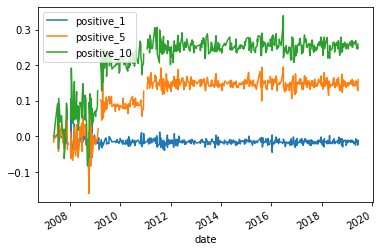

In [80]:
df_profit = pd.DataFrame(strategies['CDLBELTHOLD'])
for column in df_profit.columns:
    if not 'positive_profilt' in column:
        continue
    ret = df_profit.shift(-1)[column] - df_profit[column]
    cret_total = ret.cumsum()
    ax1 = cret_total.plot(label=column.replace('_profilt_','_'))
    h1, l1 = ax1.get_legend_handles_labels()

import matplotlib.pyplot as plt

plt.legend(h1, l1, loc=2)

plt.show()

In [67]:
df = data.talib('CDL3INSIDE')

stock_series = df[df[stock_id] != 0][stock_id]

stock_series = stock_series.dropna(axis=0)

pos = stock_series > 0
neg = stock_series < 0

strategies[fname] = {
    "positive": stock_series[pos],
    "positive_profilt_1": profit1[profit1.index.isin(pos.index)],
    "positive_profilt_5": profit5[profit5.index.isin(pos.index)],
    "positive_profilt_10": profit10[profit10.index.isin(pos.index)],
    "negative": stock_series[neg],
    "negative_profilt_1": profit1[profit1.index.isin(neg.index)],
    "negative_profilt_5": profit5[profit5.index.isin(neg.index)],
    "negative_profilt_10": profit10[profit10.index.isin(neg.index)],
}

profit1.loc[pos.index]

date
2007-07-17    0.987500
2007-10-31    0.987220
2008-04-30    0.991060
2008-09-18    0.989583
2009-04-15    1.006452
2009-11-09    0.993103
2010-02-23    0.994983
2011-04-19    1.005435
2013-01-03    1.004278
2013-06-28    1.008239
2013-09-10    0.994731
2014-03-04    1.006565
2014-05-30    1.000000
2014-10-21    0.995638
2015-03-18    1.002024
2015-04-10    1.002012
Name: 2412, dtype: float64

In [48]:
profit10['2015-03-18']

1.0020242914979758

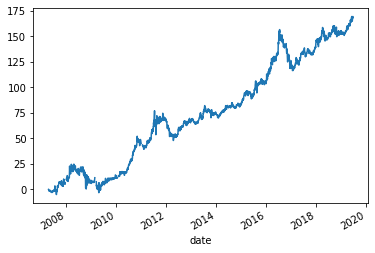

In [84]:
open_adj = data.get_adj('開盤價')
ret = open_adj.shift(-1)[stock_id] - open_adj[stock_id]

cret_total = ret.cumsum()

cret_total.plot()